# Perform noise spectroscopy
**Reconstructing noise spectra using shaped control pulses**

The Q-CTRL Python package enables you to characterize and then reconstruct power spectral densities for noise processes affecting your system. These power spectral densities can provide useful information for designing robust controls that improve the performance of the system in the presence of noise. In this notebook we show how to characterize and reconstruct noise spectra using the Q-CTRL Python package.

## Imports and initialization

All usage of the Q-CTRL Python package begins by importing the `qctrl` package and starting a session.

In [52]:
import matplotlib.pyplot as plt
import numpy as np
from qctrlopencontrols import new_modulated_gaussian_control
from qctrlvisualizer import plot_controls

from qctrl import Qctrl

colours = [
    "#E98C55",
    "#680CEA",
    "#EB6467",
]

# Starting a session with the API
qctrl = Qctrl()

## Worked example: Amplitude noise

In this example we consider a one-qubit system driven by a controllable Rabi rate that is subject to amplitude noise. The Hamiltonian of the system is:

\begin{align*}
H(t) = &\frac{1+\beta_\Omega(t)}{2} \Omega(t) \sigma_x,
\end{align*}

where $\Omega(t)$ is the controllable Rabi rate, $\beta_\Omega(t)$ is a fractional time-dependent amplitude fluctuation process and $\sigma_x$ is the Pauli X matrix. We assume that the noise process $\beta_\Omega(t)$ consists of pink noise with a small Gaussian feature, as shown below.

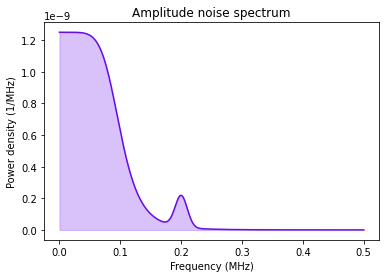

In [20]:
def gaussian(frequencies, offset, width):
    return np.exp(-0.5 * (frequencies - offset) ** 2 / width ** 2) / (
        np.sqrt(2 * np.pi) * width
    )


def pink(frequencies, frequency_cutoff, power):
    return frequency_cutoff ** (power - 1) / (
        frequencies ** power + frequency_cutoff ** power
    )


frequencies = np.linspace(0, 0.5 * 1e6, 1000)

amplitude_noise = 0.5e-11 * (
    25 * pink(frequencies=frequencies, frequency_cutoff=0.1 * 1e6, power=6)
    + gaussian(frequencies=frequencies, offset=0.2 * 1e6, width=10 * 1e3)
)

plt.plot(frequencies / 1e6, amplitude_noise * 1e6, colours[1])
plt.fill_between(
    frequencies / 1e6, 0, amplitude_noise * 1e6, alpha=0.25, color=colours[1]
)
plt.xlabel("Frequency (MHz)")
plt.ylabel("Power density (1/MHz)")
plt.title("Amplitude noise spectrum")
plt.show()

We will demonstrate how this spectrum, which would initially be unknown in practice, can be reconstructed using the Q-CTRL Python package.

As described in the introduction to this guide, the reconstruction proceeds in three stages:
1. generate a set of control pulses that are sensitive to noises at different frequencies
1. run the control pulses on the system and record the resulting infidelities
1. reconstruct the spectrum based on the control pulse sensitivities and measured infidelities.

The Q-CTRL Python package provides functionality to perform steps 1 and 3 of this procedure.

### Generating control pulses for noise characterization

The first step is to generate the set of control pulses that will be used to probe the system. This process is known as noise characterization. To perform a noise characterization, we start by generating characterization pulses using [`new_modulated_gaussian_control`](https://docs.q-ctrl.com/open-controls/references/qctrl-open-controls/qctrlopencontrols/new_modulated_gaussian_control.html) from [Q-CTRL Open Controls](https://q-ctrl.com/products/open-controls/), which requires:
- maximum Rabi rate,
- minimum segment duration (which describes the resolution for pulse shaping),
- duration (which describes the total duration of the pulse),
- modulation frequency.

Note that the modulated Gaussian control pulses are sensitive to amplitude noise at specific frequencies (determined by the modulation frequency), and therefore are suitable for reconstructing amplitude noise. However, care must be taken when choosing these values. Let the pulse duration be $T$, the minimum segment duration $t$, maximum Rabi rate $\Omega_\text{max}$ and pulse count $m$.

Generally speaking, the maximum noise frequency to which a characterization pulse is sensitive is $0.5/t$ (the Nyquist frequency). Therefore, to reconstruct a spectrum defined up to some frequency $f_\text{max}$, the minimum segment duration should be chosen as $t\approx 0.5/f_\text{max}$.

The bandwidth of each filter function, and thus the resolution of the resulting reconstruction, is roughly $2/T$. Therefore, for a pulse duration $T$, you should not expect to detect features of the noise spectrum any narrower than $2/T$.

It is important that the set of filter functions provides good coverage of the whole spectrum, with no gaps. Given that the bandwidth of each filter function is $2/T$ and the total frequency range is $0.5/t$, the number of pulses $m$ should thus be chosen on the order of $0.25T/t$. A significantly smaller value will lead to gaps in the coverage of the spectrum, while a significantly larger value does not yield any improvement in coverage and is thus unnecessary.

Finally, the maximum Rabi rate $\Omega_\text{max}$ generally controls the sensitivity of the pulses to noise at the appropriate frequency&mdash;a larger maximum Rabi rate leads to more prominent filter function peaks, and therefore a higher-quality reconstruction.

Note that if the noise spectrum is to be reconstructed in a logarithmic manner (where the desired precision decreases as the frequency increases), it may be beneficial to perform the reconstruction in separate frequency intervals. For example, if a reconstruction from 0Hz to 1MHz is desired, two individual reconstructions from 0Hz&ndash;1kHz (with 100 pulses and resolution 10Hz) and 0Hz&ndash;1MHz (with 100 pulses and resolution 10kHz) could be performed. In this way, different parameters can be used for the characterization pulses for each interval, in order to achieve higher precision at low frequencies without sacrificing computational efficiency. This approach is valid whenever the maximum Rabi rate can be chosen sufficiently high that each characterization pulse in each interval is effectively immune to noise from other intervals.

In [3]:
# Define system parameters
omega_max = 2 * np.pi * 250 * 1e6  # Hz
duration = 100 * 1e-6  # s
minimum_segment_duration = 1 * 1e-6  # s
pulse_count = 30

# Generate
noise_characterization_result = [
    new_modulated_gaussian_control(omega_max, minimum_segment_duration, duration, f)
    for f in np.linspace(0, 0.5 / minimum_segment_duration, pulse_count, endpoint=False)
]

### Visualizing the noise characterization pulses

The `noise_characterization_result` contains the pulses that must be run on the system. We first show how to extract and visualize (a subset of) the pulses.

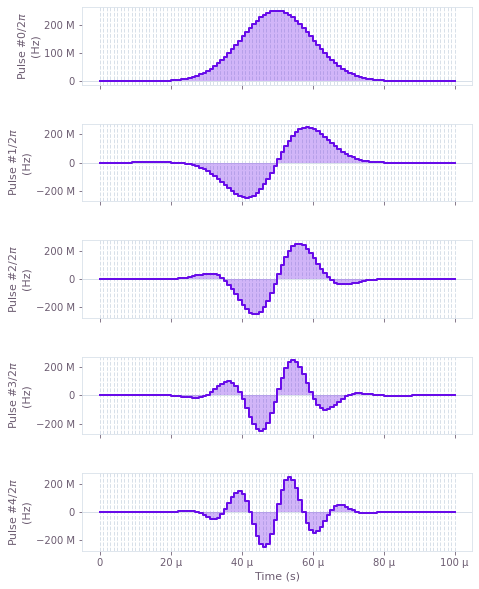

In [4]:
# Visualize first five pulses.
plot_controls(
    plt.figure(),
    {
        f"Pulse #{idx}": [
            {"duration": duration, "value": np.real(value)}
            for duration, value in zip(
                pulse.durations, pulse.rabi_rates * np.exp(1j * pulse.azimuthal_angles)
            )
        ]
        for idx, pulse in enumerate(noise_characterization_result[:5])
    },
)

### Running the characterization pulses on your system to obtain infidelities

In a noise-free system, each of the generated control pulses would effect an identity gate. In the presence of noise, however, there will be some non-zero infidelity. The next step of the reconstruction process is to calculate these infidelities. This process requires an actual system, which we do not have in this sample case, so instead we perform simulations. This computation may take a few minutes, so we cache values and only re-calculate if necessary (for example if the characterization pulses produced above have changed).

In [5]:
# Define system operators
identity = np.array([[1.0, 0.0], [0.0, 1.0]], dtype=np.complex)
sigma_x = np.array([[0.0, 1.0], [1.0, 0.0]], dtype=np.complex)

In [6]:
use_cached_data = True

if use_cached_data:
    simulated_infidelities = [
        0.006259183420207246,
        0.006673572224509753,
        0.005071129536748268,
        0.004153716811749833,
        0.003338294805623212,
        0.003025243244985263,
        0.001894390659826001,
        0.001291526390138021,
        0.0006888470402874969,
        0.00027210325699280317,
        0.00023324226993112578,
        0.00036231657462046336,
        0.00042969332727180214,
        0.00025375550668980045,
        6.326103698842751e-05,
        3.324086943771028e-05,
        1.2574731563615623e-05,
        7.67824777295904e-06,
        4.699622445705209e-06,
        5.287872980890285e-06,
        3.4688849236771033e-06,
        1.9664782988426665e-06,
        1.8743933378639887e-06,
        1.236204313896187e-06,
        1.0050979540558262e-06,
        6.414223481458296e-07,
        5.465375217461599e-07,
        4.1991613092114596e-07,
        4.0492442551591047e-07,
        3.846435542964599e-07,
    ]
    simulated_infidelity_uncertainties = [
        0.0006972015318429479,
        0.0008061552034354974,
        0.0005993405859786687,
        0.0004051001645747276,
        0.0003818868539183151,
        0.00039423375024776085,
        0.00022079694667623964,
        0.00013532400328952168,
        8.634306492354776e-05,
        2.9479202184460482e-05,
        2.87560629890493e-05,
        3.953778482912277e-05,
        5.4365122898927463e-05,
        3.1468397969610626e-05,
        6.7318024472597695e-06,
        3.8058692789993506e-06,
        1.3799521613589015e-06,
        7.582763194237108e-07,
        4.884366829670335e-07,
        5.4169239506941e-07,
        4.354614455005084e-07,
        1.848184695150225e-07,
        2.2872716793001897e-07,
        1.3433650402217778e-07,
        1.1063550672615313e-07,
        7.735861668538242e-08,
        5.233770182022276e-08,
        4.86230531496009e-08,
        5.227467190089245e-08,
        3.802586169100232e-08,
    ]
else:
    simulation_results = []
    frequency_step = np.diff(frequencies)[0]
    for pulse in noise_characterization_result:
        control = [
            qctrl.types.RealSegmentInput(duration=duration, value=np.real(value))
            for duration, value in zip(
                pulse.durations, pulse.rabi_rates * np.exp(1j * pulse.azimuthal_angles)
            )
        ]
        noise = qctrl.types.colored_noise_simulation.Noise(
            power_densities=amplitude_noise,
            frequency_step=frequency_step,
            time_domain_sample_count=100,
        )
        shift = qctrl.types.colored_noise_simulation.Shift(
            operator=sigma_x / 2, control=control, noise=noise
        )

        target = qctrl.types.TargetInput(operator=identity)

        simulation_result = qctrl.functions.calculate_colored_noise_simulation(
            duration=pulse.duration,
            shifts=[shift],
            target=target,
            trajectory_count=150,
        )
        simulation_results.append(simulation_result)

    simulated_infidelities = [
        r.average_samples[0].average_infidelity for r in simulation_results
    ]
    simulated_infidelity_uncertainties = [
        r.average_samples[0].average_infidelity_uncertainty for r in simulation_results
    ]

### Calculating the filter functions

With the infidelities in hand (which, we recall, in practice would be obtained from running the characterization pulses on an actual system rather than a simulation), we may proceed with the noise reconstruction. The next step is to calculate the filter function for each control sequence (see also the user guide for [filter function calculation](https://docs.q-ctrl.com/boulder-opal/user-guides/filter-functions)).

In [7]:
# Filter functions
minimum_frequency = 0.0  # Hz
maximum_frequency = 0.5 * 1e6  # Hz
filter_function_sample_count = 200

filter_functions = []

for pulse in noise_characterization_result:

    control = [
        qctrl.types.RealSegmentInput(duration=duration, value=np.real(value))
        for duration, value in zip(
            pulse.durations, pulse.rabi_rates * np.exp(1j * pulse.azimuthal_angles)
        )
    ]

    shift = qctrl.types.filter_function.Shift(
        operator=sigma_x / 2, control=control, noise=True
    )

    filter_function = qctrl.functions.calculate_filter_function(
        duration=pulse.duration,
        frequencies=np.linspace(minimum_frequency, maximum_frequency, 1000),
        sample_count=filter_function_sample_count,
        shifts=[shift],
    )

    filter_functions.append(filter_function)

100%|██████████| 100/100 [00:03<00:00, 29.62it/s]


### Extracting and visualizing the filter functions

Before proceeding with reconstructing noise, we note that visualizing these filter functions can provide valuable insights into the mechanism underlying the reconstruction. Here, we see that each characterization experiment is highly sensitive to noise only in the vicinity of a specific frequency. This property ensures that we can produce an accurate reconstruction even with only a small number of measurements.

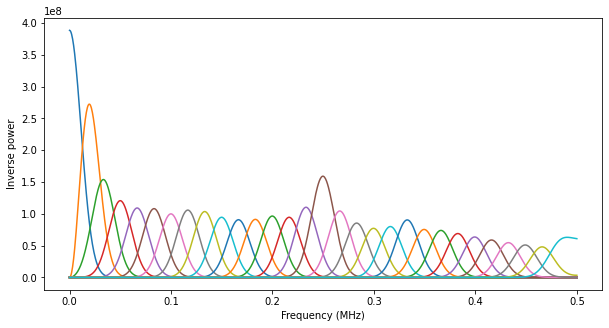

In [8]:
# Plot all filter functions.
_, ax = plt.subplots(figsize=(10, 5))
for filter_function in filter_functions:
    ax.plot(
        [sample.frequency * 1e-6 for sample in filter_function.samples],
        [sample.inverse_power for sample in filter_function.samples],
    )
plt.xlabel("Frequency (MHz)")
plt.ylabel("Inverse power")
plt.show()

### Preparing the measurement records

We have now, for each characterization pulse, filter functions that describe the pulse used for the experiment, the resulting infidelity, and infidelity uncertainties.
Before performing the noise reconstruction, we first need to pack all this information into [measurement records](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Types/noise_reconstruction/Measurement.html).

In [9]:
measurement_records = []
for idx, filter_function in enumerate(filter_functions):
    filter_function_samples = [
        qctrl.types.noise_reconstruction.FilterFunctionSample(
            frequency=sample.frequency, inverse_power=sample.inverse_power
        )
        for sample in filter_function.samples
    ]
    measurement_record = qctrl.types.noise_reconstruction.Measurement(
        infidelity=simulated_infidelities[idx],
        infidelity_uncertainty=simulated_infidelity_uncertainties[idx],
        filter_functions=[
            qctrl.types.noise_reconstruction.FilterFunction(
                samples=filter_function_samples
            )
        ],
    )
    measurement_records.append(measurement_record)

### Calculating the noise reconstruction
Now we are ready to reconstruct the noise PSD by calling the function [`qctrl.functions.calculate_noise_reconstruction`](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Functions/calculate_noise_reconstruction.html). This function provides two different methods to perform reconstruction, namely the singular value decomposition (SVD) method and convex optimization (CVX) method. You can check the note part of the function documentation for technical details about these two methods.

#### Reconstruction with SVD
[`qctrl.functions.calculate_noise_reconstruction`](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Functions/calculate_noise_reconstruction.html) uses the SVD method by default, as shown below. 

In [10]:
# Perform reconstruction with SVD
noise_reconstruction_result_svd = qctrl.functions.calculate_noise_reconstruction(
    measurements=measurement_records
)

100%|██████████| 100/100 [00:06<00:00, 14.77it/s]


#### Reconstruction with CVX
While the SVD method is computationally efficient, under certain circumstances it can give an estimation of PSD with negative powers (see the discussion in this [paper](https://arxiv.org/abs/2001.04060)). Alternatively, you can use the CVX method, as shown below.

To use the CVX method, you need to set up the [`qctrl.types.noise_reconstruction.ConvexOptimization`](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Types/noise_reconstruction/ConvexOptimization.html) object first, which includes the lower and upper bound of the noise PSD to be reconstructed, and a hyperparameter. The hyperparameter is used to control the balance between fitting the data and achieving a smooth noise PSD—a low value leads to a solution that fits the data very well at the expense of smoothness, while a high value leads to a solution is very smooth but does not fit the data as well.
    
Here we use a hard-coded value for the hyperparameter that is suitable for this particular problem, but in general you can use the conventional [cross-validation](https://en.wikipedia.org/wiki/Cross-validation_%28statistics%29) method to tune its value. Specifically, given samples of measured operational infidelities (and corresponding filter functions), you can split the dataset into training and testing data, run several reconstructions of the training data with a set of candidate hyperparameters, and choose the hyperparameter that leads to the reconstruction with minimal error (calculated on the testing data).

In [51]:
# Configure CVX method
cvx_configuration = qctrl.types.noise_reconstruction.ConvexOptimization(
    power_density_lower_bound=0,
    power_density_upper_bound=1,
    regularization_hyperparameter=1e-2,
)

# Perform reconstruction with CVX
noise_reconstruction_result_cvx = qctrl.functions.calculate_noise_reconstruction(
    measurements=measurement_records,
    method=qctrl.types.noise_reconstruction.Method(
        convex_optimization=cvx_configuration
    ),
)

100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


### Extracting and visualizing the reconstructed noise spectral density

Finally, we may extract the reconstructed noise spectral density out of the [reconstruction result](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Types/noise_reconstruction/Result.html) object. Here we plot the reconstructed spectrum against the original spectrum.

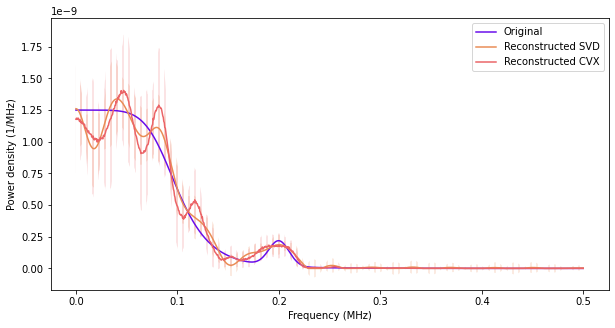

In [54]:
# Extract data
sample_frequencies = np.array(
    [
        sample.frequency
        for sample in noise_reconstruction_result_svd.power_spectral_densities[
            0
        ].samples
    ]
)
# SVD result
sample_psd_svd = np.array(
    [
        sample.power_density
        for sample in noise_reconstruction_result_svd.power_spectral_densities[
            0
        ].samples
    ]
)
sample_psd_uncertainties_svd = np.array(
    [
        sample.power_density_uncertainty
        for sample in noise_reconstruction_result_svd.power_spectral_densities[
            0
        ].samples
    ]
)
# CVX result
sample_psd_cvx = np.array(
    [
        sample.power_density
        for sample in noise_reconstruction_result_cvx.power_spectral_densities[
            0
        ].samples
    ]
)
sample_psd_uncertainties_cvx = np.array(
    [
        sample.power_density_uncertainty
        for sample in noise_reconstruction_result_cvx.power_spectral_densities[
            0
        ].samples
    ]
)

# Plot the entire noise spectral density, including uncertainties.
_, ax = plt.subplots(figsize=(10, 5))
ax.plot(frequencies * 1e-6, amplitude_noise * 1e6, label="Original", color=colours[1])
ax.plot(
    sample_frequencies * 1e-6,
    sample_psd_svd * 1e6,
    label="Reconstructed SVD",
    color=colours[0],
)
ax.fill_between(
    frequencies * 1e-6,
    (sample_psd_svd - sample_psd_uncertainties_svd) * 1e6,
    (sample_psd_svd + sample_psd_uncertainties_svd) * 1e6,
    alpha=0.35,
    hatch="||",
    facecolor="none",
    edgecolor=colours[0],
    linewidth=0,
)
ax.plot(
    sample_frequencies * 1e-6,
    sample_psd_cvx * 1e6,
    label="Reconstructed CVX",
    color=colours[2],
)
ax.fill_between(
    frequencies * 1e-6,
    (sample_psd_cvx - sample_psd_uncertainties_cvx) * 1e6,
    (sample_psd_cvx + sample_psd_uncertainties_cvx) * 1e6,
    alpha=0.35,
    hatch="||",
    facecolor="none",
    edgecolor=colours[2],
    linewidth=0,
)
ax.legend()
ax.set_xlabel("Frequency (MHz)")
ax.set_ylabel("Power density (1/MHz)")
plt.show()

### Summary

We see that the reconstructed noise spectral density matches the original noise spectral density reasonably closely, especially in terms of the large-scale trends. By taking more precise infidelity data (with lower uncertainties) we would see an even closer match between the two spectra. We have thus demonstrated how to use the Q-CTRL Python package to reconstruct the noise spectral density of an amplitude noise process affecting a single qubit system. Similar procedures may be employed to reconstruct noise spectral densities for other noise processes (for example stochastic dephasing noises) in other types of systems.